# Strategies

## Ribbon strategies

## Shark fin

In [33]:
def shark_fin(P, upper_barrier, down_strike):
    bad_condition = P > upper_barrier
    if bad_condition:
        return 0
    else:
        return max(P/down_strike-1, 0)
    
def shark_fin_weekly(week, upper_barrier, down_strike, P_last, style):
    if style == 'american':
        for P in week['close']:
            bad_condition = P > upper_barrier
            if bad_condition:
                return 0
    if P_last > upper_barrier:
        return 0
    else:
        return max(P_last/down_strike-1, 0)

In [225]:
ranges = [0.02, 0.05, 0.08, 0.1]
shark_fin_apy = pd.DataFrame(index=range(len(data_weeks_eth)), columns = [str(round(rang*100,3))+'%' for rang in ranges])
shark_fin_base_weekly_apy = 0.0075/52
for rang in ranges:
    upper_pcg = 1 + rang
    down_pcg = 1 - rang
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        strike_num=S_0*down_pcg
        upper_barrier=S_0*upper_pcg
        sigma=week['close'].pct_change().std()
        r = np.mean(week['close'].pct_change())
#         knock_out_price = binary(S_0, strike_num, upper_barrier,
#                       r_f, sigma, 'call')
#         participation_rate = (S_0*0.04/52)/knock_out_price # It doesnt make sense comparing payoff in usd against option price over premium of 1usd (it should be over option price over premium of S_0)
        knock_out_price = monte_carlo_binary(S_0, S_0*upper_pcg, S_0*down_pcg,T, r, r_f, sigma, 1, 'put')
        participation_rate = (0.04/52)/knock_out_price
#         print('Participation rate: ', participation_rate)
        if i<len(data_weeks_eth)-1:
            P_last = data_weeks_eth[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = shark_fin_weekly(week, upper_barrier, strike_num, P_last, 'european')
        shark_fin_apy[str(round(rang*100,3))+'%'].iloc[i] = shark_fin_base_weekly_apy + (week_performance_as_pcg * participation_rate)
#         print('Weekly apy: ', shark_fin_apy[str(round(rang*100,3))+'%'].iloc[i])
#         print(week_performance_as_pcg)
#         print('############################')

<ipython-input-225-6ec1544dabbc>:18: RuntimeWarning: divide by zero encountered in double_scalars
  participation_rate = (0.04/52)/knock_out_price
<ipython-input-225-6ec1544dabbc>:25: RuntimeWarning: invalid value encountered in double_scalars
  shark_fin_apy[str(round(rang*100,3))+'%'].iloc[i] = shark_fin_base_weekly_apy + (week_performance_as_pcg * participation_rate)


Results

In [226]:
(1+shark_fin_apy.dropna()).cumprod().tail()

,2.0%,5.0%,8.0%,10.0%
47,1.007165,1.007656,1.008817,1.00932
48,1.00731,1.007802,1.008967,1.009487
49,1.007489,1.007998,1.009182,1.009717
50,1.007635,1.008222,1.009432,1.009987
51,1.00778,1.008367,1.009578,1.01014


In [227]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n",(shark_fin_apy.dropna().mean()+1)**52-1)
print("\n")
print("Max:\n", (shark_fin_apy.dropna().max()+1)**52-1)

Average:
 2.0%     0.007780
5.0%     0.008367
8.0%     0.009578
10.0%    0.010140
dtype: float64


Max:
 2.0%     0.011257
5.0%     0.013233
8.0%      0.01773
10.0%    0.017588
dtype: object


Plot

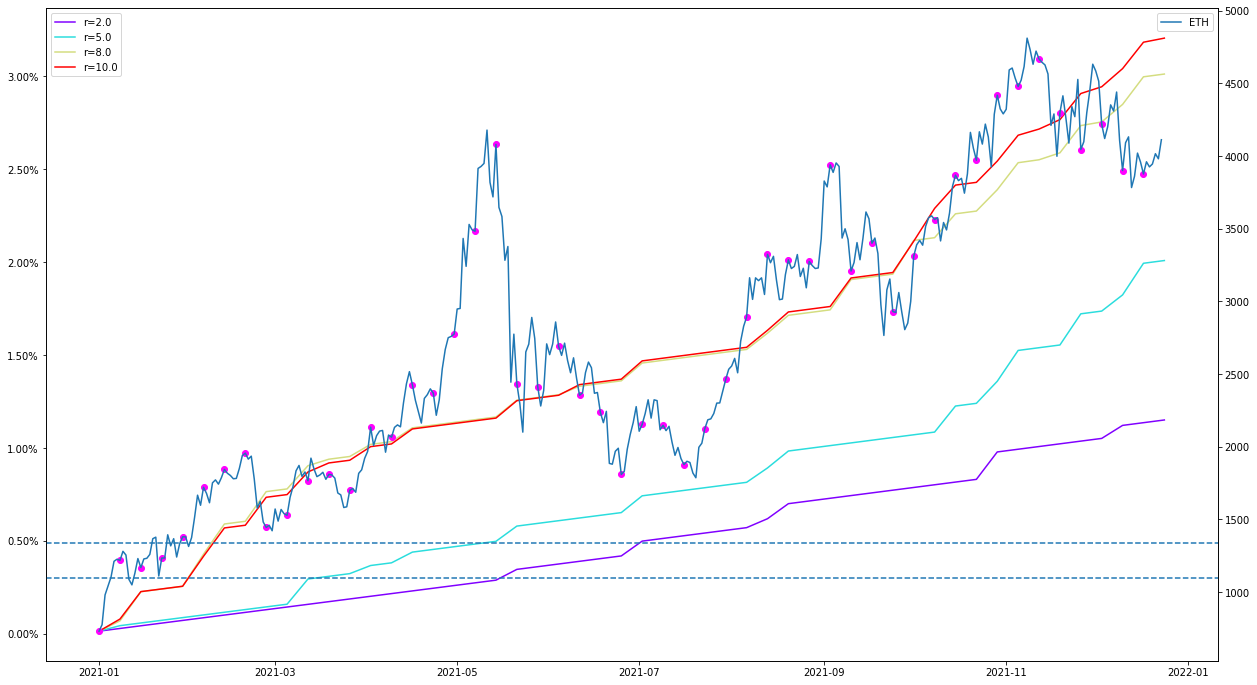

In [89]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
assets_amount = 1
i = 52
data = data_eth
color = iter(cm.rainbow(np.linspace(0, 1, len(ranges))))
for rang in ranges:
# for apy in apys:
    c = next(color)
    axs.plot(list(data.index)[::7][:i], 
            assets_amount*(1+shark_fin_apy[str(round(rang*100,3))+'%'])[:i].cumprod(),
            color=c, label='r='+str(round(rang*100,3)))
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')

axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
#              xmin=xticks_axs_[0], 
#              xmax=xticks_axs_[2], 
             linestyle='dashed')
axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
#              xmin=list(data.index)[:7*(i-1):7][1], 
#              xmax=list(data.index)[:7*(i-1):7][2], 
             linestyle='dashed')
    
axs.legend(loc='upper left')
axs_.legend(loc='upper right')

# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

## Twin win

In [37]:
def twin_win(P, P_0, upper_barrier, lower_barrier):
    bad_condition_up = P > upper_barrier
    bad_condition_down = P < lower_barrier
    if bad_condition_up | bad_condition_down:
        return 0
    else:
        return max(P_0/P -1, P/P_0 -1) 
    
def twin_win_weekly(week, upper_barrier, lower_barrier, P_last):
#     for P in week['close']:
#         bad_condition_up = P > upper_barrier
#         bad_condition_down = P < lower_barrier
#         if bad_condition_up | bad_condition_down:
#             return 0
    if (P_last > upper_barrier) | (P_last < lower_barrier):
        return 0
    else:
        return max(week['close'][0]/P_last -1, P_last/week['close'][0] -1)

In [39]:
# Specifications
upper_pcg = 1.08
down_pcg = 0.92
base_weekly_apy = 0.02/52
participation_rate_max = 0.03
participation_rate_min = 0.015
capital = 1000000
##################
acumulative_pnl = 0
twin_fin_apy_yearly = pd.DataFrame(index=range(len(data_weeks_eth)),columns=['Weekly','Yearly'])

for i in range(len(data_weeks_eth)):
    week = data_weeks_eth[i]
    P_0 = week['close'][0]
    upper_barrier = P_0 * upper_pcg
    lower_barrier = P_0 * down_pcg
    if i<len(data_weeks_eth)-1:
        P_last = data_weeks_eth[i+1]['close'][0]
    else:
        P_last = week['close'][-1]
    week_performance_as_pcg = twin_win_weekly(week, upper_barrier, lower_barrier, P_last)
    twin_fin_apy_yearly['Weekly'].iloc[i] = base_weekly_apy + (week_performance_as_pcg * 4 * participation_rate_min)
    twin_fin_apy_yearly['Yearly'].iloc[i] = base_weekly_apy + (week_performance_as_pcg * 4 * participation_rate_min + 1)**(365/28) - 1
    

In [231]:
# ranges = [0.02, 0.05, 0.08, 0.1]
twin_fin_apy = pd.DataFrame(index=range(len(data_weeks_eth)), columns = [str(round(rang*100,3))+'%' for rang in ranges])
twin_fin_apy_base_weekly_apy = 0.02/52
for rang in ranges:
    upper_pcg = 1 + rang
    down_pcg = 1 - rang
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        down_barrier=S_0*down_pcg
        upper_barrier=S_0*upper_pcg
        sigma=week['close'].pct_change().std()

#         down_out_price = binary(S_0, S_0*upper_pcg, S_0*down_pcg, 
#                       r_f, sigma, 'put')
#         up_out_price = binary(S_0, S_0*down_pcg, S_0*upper_pcg, 
#                               r_f, sigma, 'call')
#         option_price = down_out_price+up_out_price
#         participation_rate = (2*S_0*0.04/52)/option_price
        
        
        r = np.mean(week['close'].pct_change())
        down_out_price = monte_carlo_binary(S_0, S_0*upper_pcg, S_0*down_pcg, T, r, r_f, sigma, 1, 'put')
        up_out_price = monte_carlo_binary(S_0, S_0*down_pcg, S_0*upper_pcg, T, r, r_f, sigma, 1, 'call')
        option_price = down_out_price+up_out_price
        participation_rate = (2*0.04/52)/option_price
        
#         participation_rate = (0.04/52)/option_price # It doesnt make sense comparing payoff in usd against option price over premium of 1usd (it should be over option price over premium of S_0)
#         print(participation_rate)
        #         participation_rate = (0.04/52)/knock_out_price
#         print('Participation rate: ', participation_rate)
        if i<len(data_weeks_eth)-1:
            P_last = data_weeks_eth[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = twin_win_weekly(week, upper_barrier, down_barrier, P_last)
#         print(week_performance_as_pcg)
        twin_fin_apy[str(round(rang*100,3))+'%'].iloc[i] = twin_fin_apy_base_weekly_apy + (week_performance_as_pcg * participation_rate)


<ipython-input-231-42aef1e63a34>:26: RuntimeWarning: divide by zero encountered in double_scalars
  participation_rate = (2*0.04/52)/option_price
<ipython-input-231-42aef1e63a34>:38: RuntimeWarning: invalid value encountered in double_scalars
  twin_fin_apy[str(round(rang*100,3))+'%'].iloc[i] = twin_fin_apy_base_weekly_apy + (week_performance_as_pcg * participation_rate)


In [232]:
(1+twin_fin_apy.dropna()).cumprod().tail()

,2.0%,5.0%,8.0%,10.0%
47,1.018741,1.018946,1.019449,1.019471
48,1.019133,1.019338,1.019909,1.019928
49,1.019539,1.019737,1.020307,1.020325
50,1.019931,1.020164,1.020734,1.020753
51,1.020324,1.020557,1.021126,1.021225


In [233]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n",(twin_fin_apy.dropna().mean()+1)**52-1)
print("\n")
print("Max:\n", (twin_fin_apy.dropna().max()+1)**52-1)

Average:
 2.0%     0.020324
5.0%     0.020557
8.0%     0.021126
10.0%    0.021225
dtype: float64


Max:
 2.0%     0.022869
5.0%     0.024028
8.0%     0.024105
10.0%     0.02435
dtype: object


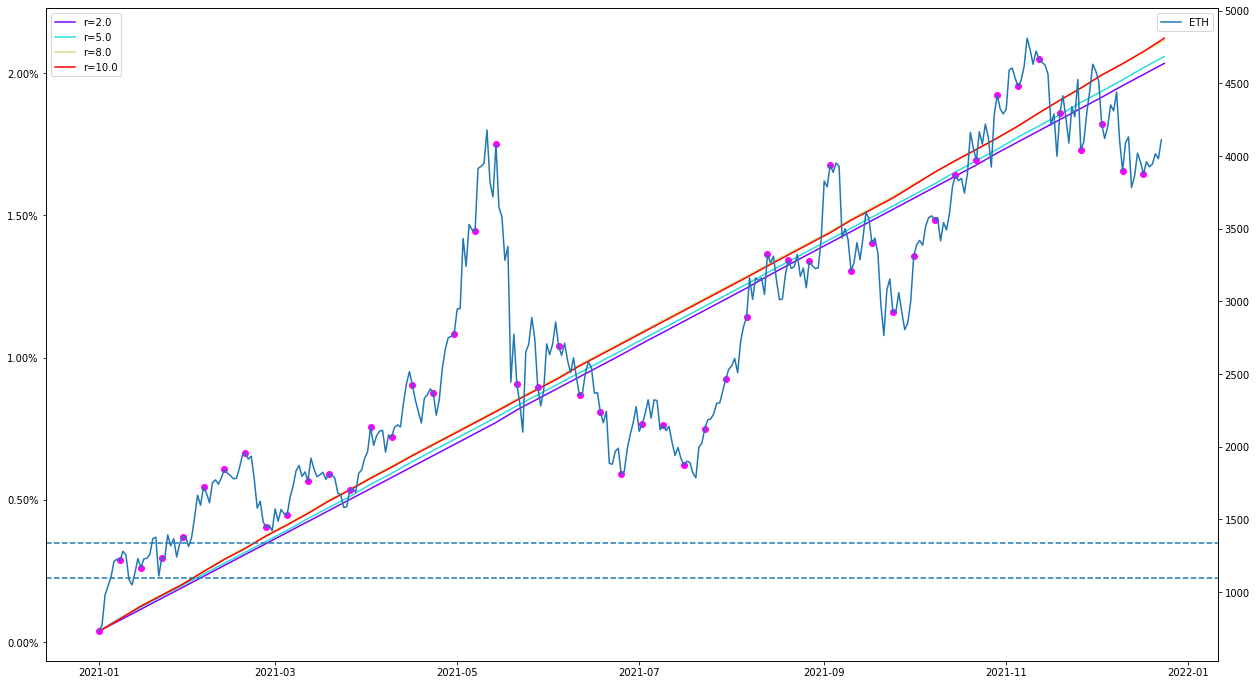

In [104]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
assets_amount = 1
i = 52
data = data_eth
color = iter(cm.rainbow(np.linspace(0, 1, len(ranges))))
for rang in ranges:
# for apy in apys:
    c = next(color)
    axs.plot(list(data.index)[::7][:i], 
            (1+twin_fin_apy[str(round(rang*100,3))+'%'])[:i].cumprod(),
            color=c, label='r='+str(round(rang*100,3)))
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')

axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
#              xmin=xticks_axs_[0], 
#              xmax=xticks_axs_[2], 
             linestyle='dashed')
axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
#              xmin=list(data.index)[:7*(i-1):7][1], 
#              xmax=list(data.index)[:7*(i-1):7][2], 
             linestyle='dashed')
    
axs.legend(loc='upper left')
axs_.legend(loc='upper right')

# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

## Gate.io strategies

## Double No Touch

In [105]:
def double_no_touch_weekly(week, upper_barrier, lower_barrier, P_last):
#     for P in week['close']:
#         bad_condition_up = P > upper_barrier
#         bad_condition_down = P < lower_barrier
#         if bad_condition_up | bad_condition_down:
#             return 0.0015
    if (P_last > upper_barrier) | (P_last < lower_barrier):
        return 0.0015
    else:
        return 0.15

In [8]:
# Specifications
upper_pcg = 1.015
down_pcg = 0.985
# base_weekly_apy = 0.0075
# participation_rate_max = 0.03
# participation_rate_min = 0.015
capital = 1
##################
acumulative_pnl = 0
double_not_touch_apy = pd.DataFrame(index=range(len(data_weeks_eth)),columns=['Weekly', 'Yearly'])

for i in range(len(data_weeks_eth)):
    week = data_weeks_eth[i]
    P_0 = week['close'][0]
    upper_barrier = P_0 * upper_pcg
    lower_barrier = P_0 * down_pcg
    if i<len(data_weeks_eth)-1:
        P_last = data_weeks_eth[i+1]['close'][0]
    else:
        P_last = week['close'][-1]
    week_performance_as_pcg = double_no_touch_weekly(week, upper_barrier, lower_barrier, P_last)
    double_not_touch_apy['Weekly'].iloc[i] = capital * week_performance_as_pcg/365*7
    double_not_touch_apy['Yearly'].iloc[i] = capital * week_performance_as_pcg
    

In [245]:
double_not_touch_apy['Weekly']

0     2.87671e-05
1     2.87671e-05
2     2.87671e-05
3     2.87671e-05
4     2.87671e-05
5     2.87671e-05
6     2.87671e-05
7     2.87671e-05
8     2.87671e-05
9     2.87671e-05
10    2.87671e-05
11    2.87671e-05
12    2.87671e-05
13    2.87671e-05
14    2.87671e-05
15    2.87671e-05
16    2.87671e-05
17    2.87671e-05
18    2.87671e-05
19    2.87671e-05
20     0.00287671
21    2.87671e-05
22    2.87671e-05
23    2.87671e-05
24    2.87671e-05
25    2.87671e-05
26     0.00287671
27    2.87671e-05
28    2.87671e-05
29    2.87671e-05
30    2.87671e-05
31    2.87671e-05
32     0.00287671
33     0.00287671
34    2.87671e-05
35    2.87671e-05
36    2.87671e-05
37    2.87671e-05
38    2.87671e-05
39    2.87671e-05
40    2.87671e-05
41    2.87671e-05
42    2.87671e-05
43     0.00287671
44    2.87671e-05
45    2.87671e-05
46    2.87671e-05
47    2.87671e-05
48    2.87671e-05
49     0.00287671
50    2.87671e-05
51    2.87671e-05
52    2.87671e-05
Name: Weekly, dtype: object

In [246]:
np.mean(double_not_touch_apy['Weekly']==0.0015/365*7), (1+double_not_touch_apy['Weekly']).cumprod().tail()

(0.8867924528301887,
 48    1.01575
 49    1.01867
 50     1.0187
 51    1.01873
 52    1.01876
 Name: Weekly, dtype: object)

NameError: name 'data' is not defined

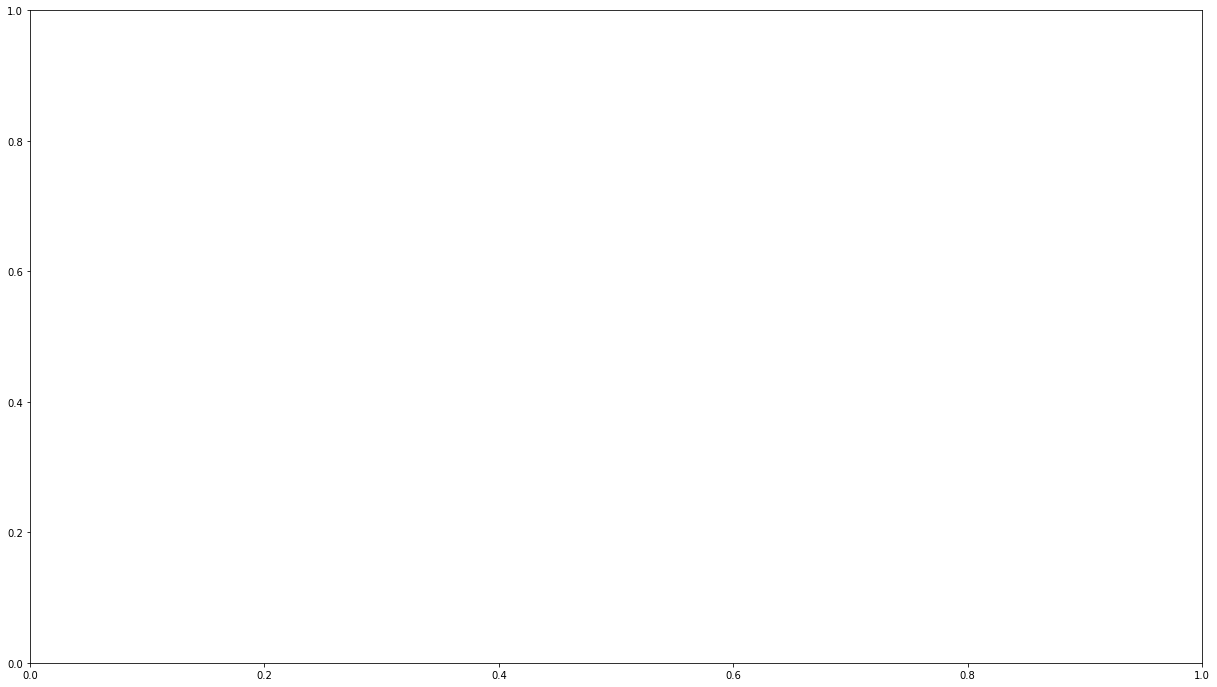

In [247]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i=52
axs.plot(list(data.index)[::7][:i], 
        (1+double_not_touch_apy['Weekly']).cumprod()[:i],
        color='tab:red', label='STGY')
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')
axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
#              xmin=xticks_axs_[0], 
#              xmax=xticks_axs_[2], 
             linestyle='dashed')
axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
#              xmin=list(data.index)[:7*(i-1):7][1], 
#              xmax=list(data.index)[:7*(i-1):7][2], 
             linestyle='dashed')
print(double_not_touch_apy['Weekly'][:i])

axs.legend(loc='upper left')

# manipulate
# vals = axs.get_yticks()
axs.set_yticklabels([f'{x-1:.3%}' for x in axs.get_yticks()]) 
plt.show()

## Daily Smile

In [106]:
def daily_smile_weekly(week, upper_barrier, lower_barrier, P_last):
    yearly_apys = []
#     for P in week['close']:
#         bad_condition_up = P > upper_barrier
#         bad_condition_down = P < lower_barrier
#         if bad_condition_up | bad_condition_down:
#             yearly_apys.append(0.0040)
#         else:
#             yearly_apys.append(0.0650)
    if (P_last > upper_barrier) | (P_last < lower_barrier):
        yearly_apys.append(0.0040)
    else:
        yearly_apys.append(0.0650)
    return yearly_apys

In [235]:
# Specifications
upper_pcg = 1.015
down_pcg = 0.985
# base_weekly_apy = 0.0075
# participation_rate_max = 0.03
# participation_rate_min = 0.015
capital = 1
##################
acumulative_pnl = 0
daily_smile_apy = pd.DataFrame(index=range(len(data_weeks)),columns=['Weekly','Yearly'])

for i in range(len(data_weeks)):
    week = data_weeks[i]
    P_0 = week['close'][0]
    upper_barrier = P_0 * upper_pcg
    lower_barrier = P_0 * down_pcg
    if i<len(data_weeks)-1:
        P_last = data_weeks[i+1]['close'][0]
    else:
        P_last = week['close'][-1]
    week_apys = daily_smile_weekly(week, upper_barrier, lower_barrier, P_last)
    week_returns = [capital * i/365 for i in week_apys]
    daily_smile_apy['Weekly'].iloc[i] = sum(week_returns)/capital
    daily_smile_apy['Yearly'].iloc[i] = (1+sum(week_returns))**52-1
    

In [238]:
(1+daily_smile_apy['Weekly']).cumprod().tail()

48    1.00137
49    1.00155
50    1.00156
51    1.00157
52    1.00158
Name: Weekly, dtype: object

In [ ]:
# np.mean(double_not_touch_apy['Weekly']==0.0015/365*7), (1+double_not_touch_apy['Weekly']).cumprod().tail()

0     1.09589e-05
1     1.09589e-05
2     1.09589e-05
3     1.09589e-05
4     1.09589e-05
5     1.09589e-05
6     1.09589e-05
7     1.09589e-05
8     1.09589e-05
9     1.09589e-05
10    1.09589e-05
11    1.09589e-05
12    1.09589e-05
13    1.09589e-05
14    1.09589e-05
15    1.09589e-05
16    1.09589e-05
17    1.09589e-05
18    1.09589e-05
19    1.09589e-05
20    0.000178082
21    1.09589e-05
22    1.09589e-05
23    1.09589e-05
24    1.09589e-05
25    1.09589e-05
26    0.000178082
27    1.09589e-05
28    1.09589e-05
29    1.09589e-05
30    1.09589e-05
31    1.09589e-05
32    0.000178082
33    0.000178082
34    1.09589e-05
35    1.09589e-05
36    1.09589e-05
37    1.09589e-05
38    1.09589e-05
39    1.09589e-05
40    1.09589e-05
41    1.09589e-05
42    1.09589e-05
43    0.000178082
44    1.09589e-05
45    1.09589e-05
46    1.09589e-05
47    1.09589e-05
48    1.09589e-05
49    0.000178082
50    1.09589e-05
51    1.09589e-05
Name: Weekly, dtype: object


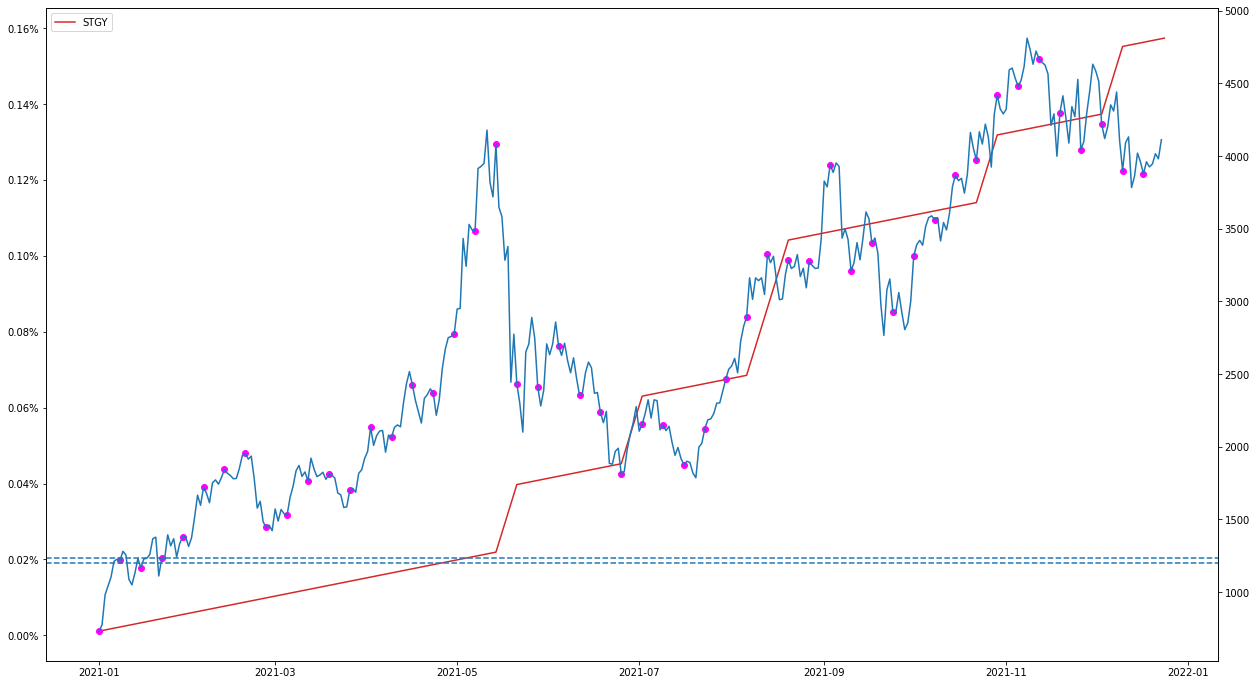

In [239]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i=52
axs.plot(list(data.index)[::7][:i], 
        (1+daily_smile_apy['Weekly']).cumprod()[:i],
        color='tab:red', label='STGY')

axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')
axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
#              xmin=xticks_axs_[0], 
#              xmax=xticks_axs_[2], 
             linestyle='dashed')
axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
#              xmin=list(data.index)[:7*(i-1):7][1], 
#              xmax=list(data.index)[:7*(i-1):7][2], 
             linestyle='dashed')
print(daily_smile_apy['Weekly'][:i])

axs.legend(loc='upper left')

# manipulate
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

In [144]:
(1+daily_smile_apy['Weekly']).cumprod(), (1+daily_smile_apy['Yearly']).cumprod()

(0     1.00025
 1     1.00068
 2     1.00093
 3     1.00152
 4     1.00211
        ...   
 86    1.04294
 87    1.04373
 88    1.04417
 89    1.04443
 90    1.04575
 Name: Weekly, Length: 91, dtype: object,
 0     1.01334
 1     1.03581
 2     1.04962
 3     1.08226
 4     1.11591
        ...   
 86    8.90179
 87    9.25865
 88    9.46398
 89    9.59019
 90    10.2379
 Name: Yearly, Length: 91, dtype: object)